In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os
import matplotlib.pyplot as plt

2025-05-14 12:24:59.635567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 12:24:59.635892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 12:24:59.637807: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 12:24:59.643605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747239899.653758  119492 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747239899.65

In [2]:
# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [3]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

2025-05-14 12:25:12.987110: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modelo cargado desde final_model_fine_tuned_v2.keras


In [4]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

In [5]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones imagen: "+image_path)
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
Predicciones imagen: ../data/predecir/Siniestro_02.jpg

Partes:
- Parachoques delantero: 49.23%
- Guardabarros trasero izquierdo: 22.91%
- Guardabarros delantero derecho: 21.42%

Dannos:
- Abolladura: 56.18%
- Rayón: 51.03%
- Rotura: 33.92%

Sugerencias:
- Reparar: 90.60%
- Reemplazar: 18.84%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


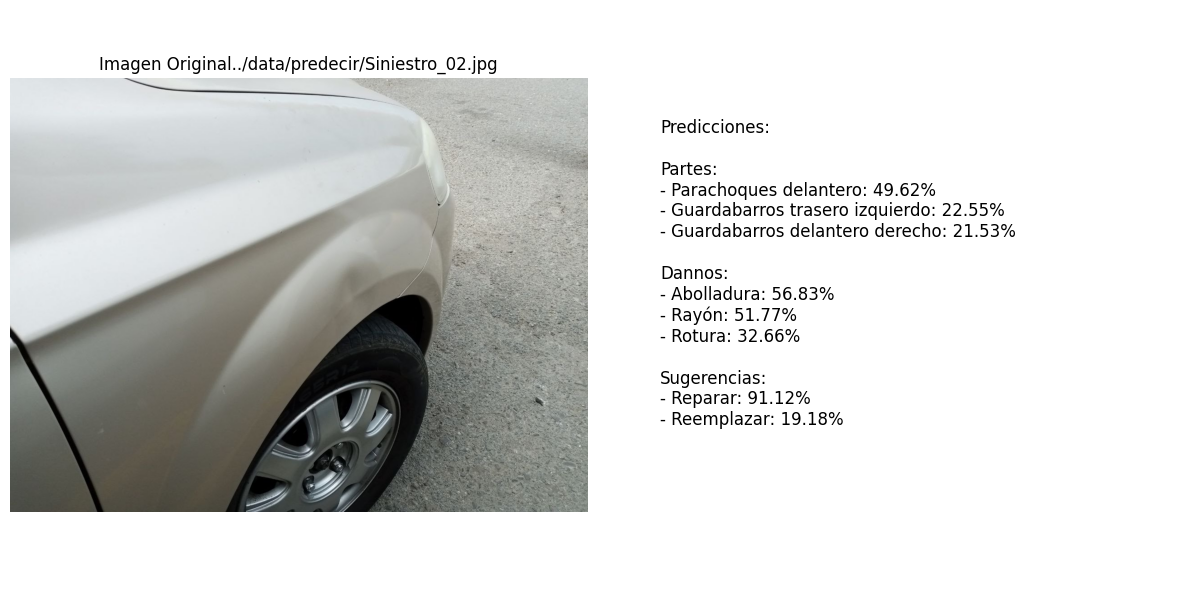

In [6]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original"+image_path)
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

---

Prediciendo, usando custom thresholds

In [7]:
import os
import json
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import applications

In [8]:
def load_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

In [9]:
def load_mlb_objects():
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)
    return mlb_partes, mlb_dannos, mlb_sugerencias

In [10]:
def load_thresholds(thresholds_path):
    if not os.path.exists(thresholds_path):
        raise FileNotFoundError(f"El archivo de umbrales no existe: {thresholds_path}")
    with open(thresholds_path, 'r') as f:
        thresholds = json.load(f)
    return thresholds

In [11]:
def preprocess_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [12]:
def predict_with_thresholds(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds_partes, img_size=(224, 224)):
    img_array = preprocess_image(image_path, img_size)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Aplicar umbrales personalizados para partes
    partes_pred = []
    for i, cls in enumerate(mlb_partes.classes_):
        cls_name = str(cls)
        threshold = thresholds_partes.get(cls_name, 0.5)  # usar 0.5 si no está definido
        partes_pred.append((cls_name, partes_probs[i], partes_probs[i] >= threshold))

    # Para daños y sugerencias se usa umbral fijo 0.5 (puede extenderse si se desea)
    dannos_pred = [(str(cls), dannos_probs[i], dannos_probs[i] >= 0.5) for i, cls in enumerate(mlb_dannos.classes_)]
    sugerencias_pred = [(str(cls), sugerencias_probs[i], sugerencias_probs[i] >= 0.5) for i, cls in enumerate(mlb_sugerencias.classes_)]

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [13]:
if __name__ == "__main__":
    model_path = "final_model_fine_tuned_v2.keras"
    thresholds_path = "optimal_thresholds_partes.json"
    model = load_model(model_path)
    mlb_partes, mlb_dannos, mlb_sugerencias = load_mlb_objects()
    thresholds_partes = load_thresholds(thresholds_path)

Modelo cargado desde final_model_fine_tuned_v2.keras


In [14]:
def print_predictions(predictions, label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    print("\nPredicciones para la imagen:", image_path," con umbrales personalizados:\n")

    print("Partes:")
    # Ordenar de mayor a menor probabilidad
    partes_sorted = sorted(predictions['partes'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in partes_sorted:
        name = label_to_cls_piezas.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

    print("\nDaños:")
    daños_sorted = sorted(predictions['dannos'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in daños_sorted:
        name = label_to_cls_danos.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

    print("\nSugerencias:")
    sugerencias_sorted = sorted(predictions['sugerencias'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in sugerencias_sorted:
        name = label_to_cls_sugerencias.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

if __name__ == "__main__":
    # model_path = "final_model_fine_tuned_v2.keras"
    # thresholds_path = "optimal_thresholds_partes.json"
    ### image_path = "../data/predecir/golpe_03.jpg"

    label_to_cls_piezas = {
        1: "Antiniebla delantero derecho",
        2: "Antiniebla delantero izquierdo",
        3: "Capó",
        4: "Cerradura capo",
        5: "Cerradura maletero",
        6: "Cerradura puerta",
        7: "Espejo lateral derecho",
        8: "Espejo lateral izquierdo",
        9: "Faros derecho",
        10: "Faros izquierdo",
        11: "Guardabarros delantero derecho",
        12: "Guardabarros delantero izquierdo",
        13: "Guardabarros trasero derecho",
        14: "Guardabarros trasero izquierdo",
        15: "Luz indicadora delantera derecha",
        16: "Luz indicadora delantera izquierda",
        17: "Luz indicadora trasera derecha",
        18: "Luz indicadora trasera izquierda",
        19: "Luz trasera derecho",
        20: "Luz trasera izquierdo",
        21: "Maletero",
        22: "Manija derecha",
        23: "Manija izquierda",
        24: "Marco de la ventana",
        25: "Marco de las puertas",
        26: "Moldura capó",
        27: "Moldura puerta delantera derecha",
        28: "Moldura puerta delantera izquierda",
        29: "Moldura puerta trasera derecha",
        30: "Moldura puerta trasera izquierda",
        31: "Parabrisas delantero",
        32: "Parabrisas trasero",
        33: "Parachoques delantero",
        34: "Parachoques trasero",
        35: "Puerta delantera derecha",
        36: "Puerta delantera izquierda",
        37: "Puerta trasera derecha",
        38: "Puerta trasera izquierda",
        39: "Rejilla, parrilla",
        40: "Rueda",
        41: "Tapa de combustible",
        42: "Tapa de rueda",
        43: "Techo",
        44: "Techo corredizo",
        45: "Ventana delantera derecha",
        46: "Ventana delantera izquierda",
        47: "Ventana trasera derecha",
        48: "Ventana trasera izquierda",
        49: "Ventanilla delantera derecha",
        50: "Ventanilla delantera izquierda",
        51: "Ventanilla trasera derecha",
        52: "Ventanilla trasera izquierda"
    }

    label_to_cls_danos = {
        1: "Abolladura",
        2: "Deformación",
        3: "Desprendimiento",
        4: "Fractura",
        5: "Rayón",
        6: "Rotura"
    }

    label_to_cls_sugerencias = {
        1: "Reparar",
        2: "Reemplazar"
    }

    # model = load_model(model_path)
    # mlb_partes, mlb_dannos, mlb_sugerencias = load_mlb_objects()
    # thresholds_partes = load_thresholds(thresholds_path)

    predictions = predict_with_thresholds(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds_partes)
    print_predictions(predictions, label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step

Predicciones para la imagen: ../data/predecir/Siniestro_02.jpg  con umbrales personalizados:

Partes:
- Parachoques delantero: 49.23% - Negativo
- Guardabarros trasero izquierdo: 22.91% - Negativo
- Guardabarros delantero derecho: 21.42% - Negativo
- Rueda: 19.52% - Negativo
- Guardabarros trasero derecho: 19.40% - Negativo
- Guardabarros delantero izquierdo: 19.36% - Negativo
- Faros derecho: 15.23% - Negativo
- Parachoques trasero: 14.47% - Negativo
- Marco de las puertas: 13.91% - Negativo
- Faros izquierdo: 12.87% - Negativo
- Puerta delantera derecha: 12.65% - Negativo
- Puerta trasera derecha: 11.59% - Negativo
- Maletero: 11.29% - Negativo
- Puerta trasera izquierda: 11.17% - Negativo
- Puerta delantera izquierda: 10.59% - Negativo
- Capó: 10.18% - Negativo
- Luz indicadora delantera izquierda: 8.64% - Negativo
- Luz indicadora delantera derecha: 8.27% - Negativo
- Parabrisas trasero: 8.14% - Negativo
- Clase_999: 7.86% - Negativo
- Luz tr

---